In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pygad
import wandb

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

tf.random.set_seed(0)
np.random.seed(0)

import scipy.io as sio

Number of 6s in the new dataset: 592
Number of 0s in the new dataset: 5923


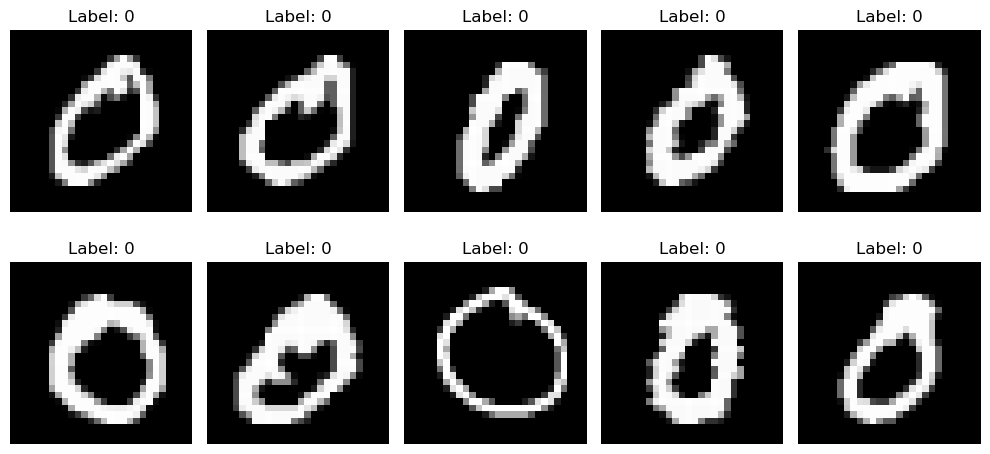

In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Filter 6s from the dataset
indices_6 = np.where(y_train == 0)[0]
filtered_images = x_train[indices_6]
filtered_labels = y_train[indices_6]

# Select a few 0s
indices_0 = np.where(y_train == 6)[0][:len(indices_6) // 10]  # Select 1/5th of the number of 6s
selected_images = x_train[indices_0]
selected_labels = y_train[indices_0]

# Combine the selected images (6s) with the few 0s
combined_images = np.concatenate((filtered_images, selected_images))
combined_labels = np.concatenate((filtered_labels, selected_labels))

# Count the occurrences of each label (6 or 0) in the combined dataset
num_6s = np.sum(combined_labels == 6)
num_0s = np.sum(combined_labels == 0)

# Display the counts
print(f"Number of 6s in the new dataset: {num_6s}")
print(f"Number of 0s in the new dataset: {num_0s}")

# Visualize some samples from the custom dataset
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(combined_images[i], cmap='gray')
    plt.title(f'Label: {combined_labels[i]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Save the custom dataset
np.savez_compressed('custom_mnist.npz', images=combined_images, labels=combined_labels)


Shape of reshaped images: (6515, 784)


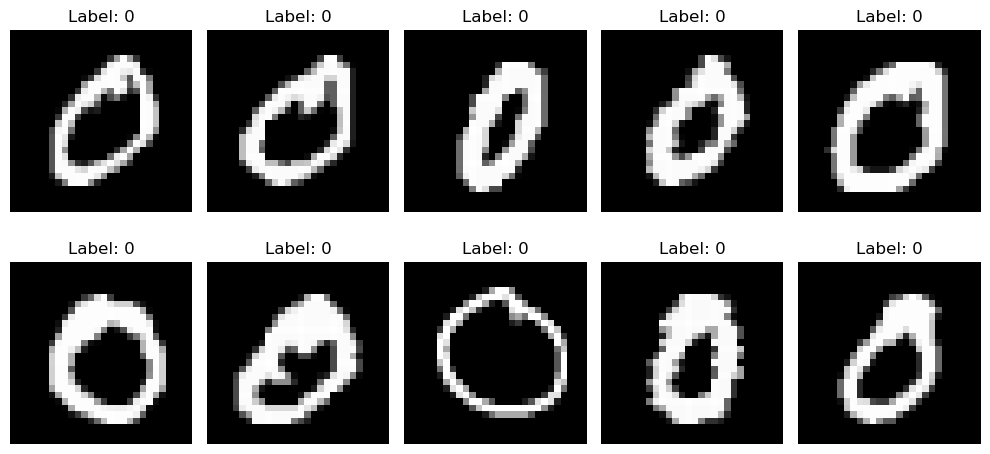

Original dataset shape: (6515, 28, 28)
Downsampled dataset shape: (6515, 15, 15)


In [82]:
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
# Load the custom dataset
custom_dataset = np.load('custom_mnist.npz')
combined_images = custom_dataset['images']
combined_labels = custom_dataset['labels']

# Reshape the images as 1D arrays
num_images = len(combined_images)
image_size = combined_images.shape[1] * combined_images.shape[2]
reshaped_images = combined_images.reshape(num_images, image_size)

# Display the shape of the reshaped images
print("Shape of reshaped images:", reshaped_images.shape)

# Visualize some reshaped images
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(reshaped_images[i].reshape(28, 28), cmap='gray')
    plt.title(f'Label: {combined_labels[i]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

output_size = (15, 15)

downsampled_images = np.zeros((combined_images.shape[0], *output_size))

# Downsample each image in the dataset
for i, image in enumerate(combined_images):
    downsampled_images[i] = zoom(image, (output_size[0] / image.shape[0], output_size[1] / image.shape[1]))

image_size = downsampled_images.shape[1] * downsampled_images.shape[2]
reshaped_images = downsampled_images.reshape(num_images, image_size)

# Verify the shape of the downsampled images
print("Original dataset shape:", combined_images.shape)
print("Downsampled dataset shape:", downsampled_images.shape)


# Training the VAE

In [83]:
normalized_images = reshaped_images / 255.0


class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


latent_dim = 16

encoder_inputs = keras.Input(shape=(225,))
# x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
# x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
# x = layers.Flatten()(x)
x = layers.Dense(512, activation="relu")(encoder_inputs)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

latent_inputs = keras.Input(shape=(latent_dim,))
# x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
# x = layers.Reshape((7, 7, 64))(x)
# x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
# x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
# decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
x = layers.Dense(64, activation="relu")(latent_inputs)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(512, activation="relu")(x)
decoder_outputs = layers.Dense(225, activation="tanh")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")



class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
#             reconstruction_loss = tf.reduce_mean(
#                 tf.reduce_sum(
#                     keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
#                 )
#             )
            reconstruction_loss = tf.keras.losses.MeanSquaredError()(data,reconstruction)
#             reconstruction_loss = tf.keras.losses.BinaryCrossentropy()(data, reconstruction)
#             
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
#             kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss +  0.1 * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# mnist_data = mat_data['X']
tdata = np.concatenate([normalized_images], axis=0)
tdata = np.expand_dims(tdata, -1).astype("float32")

vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.legacy.Adam())
history = vae.fit(tdata, epochs=100, batch_size=1024)

Epoch 1/100
7/7 [==============================] - 2s 19ms/step - loss: 0.1179 - reconstruction_loss: 0.0992 - kl_loss: 0.0057
Epoch 2/100
7/7 [==============================] - 0s 16ms/step - loss: 0.0678 - reconstruction_loss: 0.0659 - kl_loss: 0.0021
Epoch 3/100
7/7 [==============================] - 0s 16ms/step - loss: 0.0627 - reconstruction_loss: 0.0618 - kl_loss: 0.0012
Epoch 4/100
7/7 [==============================] - 0s 16ms/step - loss: 0.0603 - reconstruction_loss: 0.0598 - kl_loss: 0.0014
Epoch 5/100
7/7 [==============================] - 0s 16ms/step - loss: 0.0592 - reconstruction_loss: 0.0589 - kl_loss: 0.0018
Epoch 6/100
7/7 [==============================] - 0s 16ms/step - loss: 0.0587 - reconstruction_loss: 0.0586 - kl_loss: 0.0020
Epoch 7/100
7/7 [==============================] - 0s 16ms/step - loss: 0.0581 - reconstruction_loss: 0.0580 - kl_loss: 0.0032
Epoch 8/100
7/7 [==============================] - 0s 16ms/step - loss: 0.0578 - reconstruction_loss: 0.0571 - 

7/7 [==============================] - 0s 15ms/step - loss: 0.0517 - reconstruction_loss: 0.0456 - kl_loss: 0.0631
Epoch 66/100
7/7 [==============================] - 0s 15ms/step - loss: 0.0520 - reconstruction_loss: 0.0452 - kl_loss: 0.0643
Epoch 67/100
7/7 [==============================] - 0s 15ms/step - loss: 0.0517 - reconstruction_loss: 0.0452 - kl_loss: 0.0662
Epoch 68/100
7/7 [==============================] - 0s 15ms/step - loss: 0.0515 - reconstruction_loss: 0.0453 - kl_loss: 0.0640
Epoch 69/100
7/7 [==============================] - 0s 15ms/step - loss: 0.0516 - reconstruction_loss: 0.0448 - kl_loss: 0.0682
Epoch 70/100
7/7 [==============================] - 0s 15ms/step - loss: 0.0515 - reconstruction_loss: 0.0450 - kl_loss: 0.0662
Epoch 71/100
7/7 [==============================] - 0s 15ms/step - loss: 0.0514 - reconstruction_loss: 0.0446 - kl_loss: 0.0682
Epoch 72/100
7/7 [==============================] - 0s 15ms/step - loss: 0.0516 - reconstruction_loss: 0.0446 - kl_lo

In [63]:
out_rec = []

for i in range(combined_labels.shape[0]):
    
    if combined_labels[i] == 0:
        
        sample = normalized_images[i,:].reshape([1,784])

        z_mean, z_log_var, z = vae.encoder(sample)
        reconstruction = vae.decoder(z)

        reconstruction_loss = tf.keras.losses.MeanSquaredError()(sample,reconstruction)
        out_rec.append(reconstruction_loss.numpy())

print("Mean = ", np.mean(np.array(out_rec)))
print("Std = ", np.std(np.array(out_rec)))

Mean =  0.055276103
Std =  0.015721928


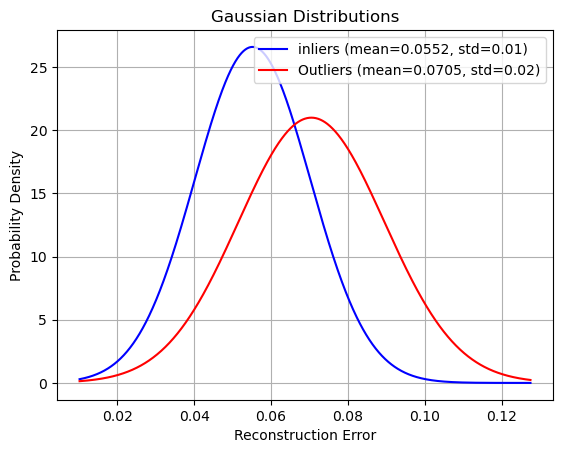

In [64]:
import numpy as np
import matplotlib.pyplot as plt

# Example usage:
mean1 = 0.0552
std1 = 0.015
mean2 = 0.0705
std2 = 0.019

def gaussian(x, mean, std):
    """
    Compute the Gaussian probability density function.

    Parameters:
        x (numpy array): The input values.
        mean (float): Mean of the Gaussian distribution.
        std (float): Standard deviation of the Gaussian distribution.

    Returns:
        numpy array: The Gaussian probability density function values.
    """
    exponent = -0.5 * ((x - mean) / std)**2
    return (1 / (std * np.sqrt(2 * np.pi))) * np.exp(exponent)

def plot_gaussian(mean1, std1, mean2, std2):
    """
    Plot two Gaussian distributions with given means and standard deviations.

    Parameters:
        mean1 (float): Mean of the first Gaussian distribution.
        std1 (float): Standard deviation of the first Gaussian distribution.
        mean2 (float): Mean of the second Gaussian distribution.
        std2 (float): Standard deviation of the second Gaussian distribution.

    Returns:
        None
    """
    x = np.linspace(min(mean1 - 3 * std1, mean2 - 3 * std2), max(mean1 + 3 * std1, mean2 + 3 * std2), 1000)
    gaussian1 = gaussian(x, mean1, std1)
    gaussian2 = gaussian(x, mean2, std2)

    plt.plot(x, gaussian1, label=f"inliers (mean={mean1}, std={std1:.2f})", color='blue')
    plt.plot(x, gaussian2, label=f"Outliers (mean={mean2}, std={std2:.2f})", color='red')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Probability Density')
    plt.title('Gaussian Distributions')
    plt.legend()
    plt.grid(True)
    plt.show()



plot_gaussian(mean1, std1, mean2, std2)


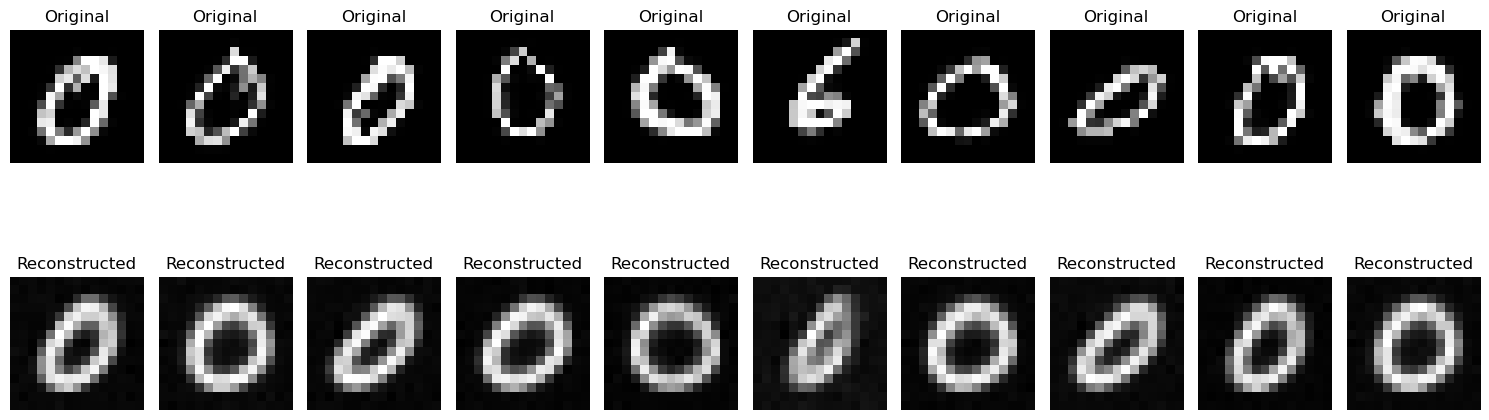

In [84]:
num_reconstructed_images = 10

random_indices = np.random.choice(len(downsampled_images), num_reconstructed_images, replace=False)
selected_images = normalized_images[random_indices]

# Reconstruct the selected images using the VAE
reconstructed_images = []

for i in range(num_reconstructed_images):
    
    sample = selected_images[i].reshape([1,225])
    
    z_mean, z_log_var, z = vae.encoder(sample)
    reconstruction = vae.decoder(z)
    
    reconstructed_images.append(reconstruction)

reconstructed_images = np.array(reconstructed_images)
# Display the original and reconstructed images side by side
plt.figure(figsize=(15, 6))
for i in range(num_reconstructed_images):
    plt.subplot(2, num_reconstructed_images, i + 1)
    plt.imshow(selected_images[i].reshape(15, 15), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    plt.subplot(2, num_reconstructed_images, i + num_reconstructed_images + 1)
    plt.imshow(reconstructed_images[i].reshape(15, 15), cmap='gray')
    plt.title('Reconstructed')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [42]:
reconstructed_images

array([[[-0.0007162 ,  0.00501391,  0.00183747, ..., -0.00039258,
         -0.00075549,  0.00010752]],

       [[ 0.00399861,  0.00148344,  0.00172737, ..., -0.00166898,
          0.0017484 , -0.00406089]],

       [[ 0.00284633,  0.00176892, -0.00188989, ..., -0.00220107,
         -0.00429917,  0.00188573]],

       ...,

       [[ 0.00157055,  0.00113618, -0.00017581, ..., -0.0018446 ,
         -0.00064255,  0.00039707]],

       [[-0.00073598, -0.00031826, -0.00495016, ...,  0.00266428,
          0.0014387 ,  0.00026181]],

       [[ 0.0030814 ,  0.00046717,  0.00177121, ...,  0.00076055,
          0.0025324 ,  0.00033648]]], dtype=float32)

Indices of 6s: [5923 5924 5925 5926 5927 5928 5929 5930 5931 5932 5933 5934 5935 5936
 5937 5938 5939 5940 5941 5942 5943 5944 5945 5946 5947 5948 5949 5950
 5951 5952 5953 5954 5955 5956 5957 5958 5959 5960 5961 5962 5963 5964
 5965 5966 5967 5968 5969 5970 5971 5972 5973 5974 5975 5976 5977 5978
 5979 5980 5981 5982 5983 5984 5985 5986 5987 5988 5989 5990 5991 5992
 5993 5994 5995 5996 5997 5998 5999 6000 6001 6002 6003 6004 6005 6006
 6007 6008 6009 6010 6011 6012 6013 6014 6015 6016 6017 6018 6019 6020
 6021 6022 6023 6024 6025 6026 6027 6028 6029 6030 6031 6032 6033 6034
 6035 6036 6037 6038 6039 6040 6041 6042 6043 6044 6045 6046 6047 6048
 6049 6050 6051 6052 6053 6054 6055 6056 6057 6058 6059 6060 6061 6062
 6063 6064 6065 6066 6067 6068 6069 6070 6071 6072 6073 6074 6075 6076
 6077 6078 6079 6080 6081 6082 6083 6084 6085 6086 6087 6088 6089 6090
 6091 6092 6093 6094 6095 6096 6097 6098 6099 6100 6101 6102 6103 6104
 6105 6106 6107 6108 6109 6110 6111 6112 6113 6114 6115 6116 6

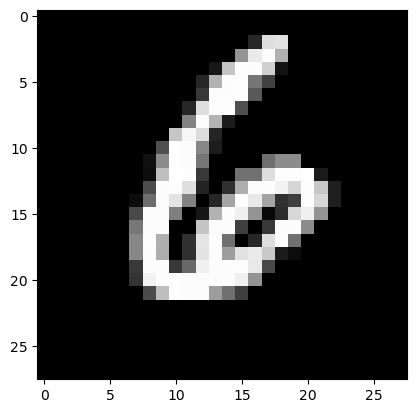

In [41]:
indices_6 = np.where(combined_labels == 6)[0]

# Display the indices of 6s
print("Indices of 6s:", indices_6)
plt.imshow(normalized_images[indices_6[0]].reshape(28, 28), cmap='gray')

In [85]:
# sols = []

# wandb.init(
#     # set the wandb project where this run will be logged
#     project="VAE_Outlier_GA_MNIST_subspace_detection_1",
    
#     # track hyperparameters and run metadata
# #     config={
# #     "learning_rate": 0.02,
# #     "architecture": "CNN",
# #     "dataset": "CIFAR-100",
# #     "epochs": 20,
# #     }
# )

# for out_number in range(100):

def fitness_func_avg(ga_instance, solution, solution_idx):

    inliers = normalized_images[10:13]

    avg_ins = np.mean(inliers, axis=0)
    avg_ins = avg_ins.reshape([1,225])

    particle = normalized_images[indices_6[0]]
    particle = particle.reshape([1,225])

#     abn_subspace = solution * val_features[6728,:]

#     abn_subspace = abn_subspace.reshape([1,30])

    avg_in_rec = []

    for index in range(inliers.shape[0]):

        candidate_inlier = inliers[index,:]
        candidate_inlier = candidate_inlier.reshape([1,225])

        in_remain = candidate_inlier * solution

        in_normal_subspace = 1 - solution

        in_replace = in_normal_subspace * avg_ins

        in_candidate = in_remain + in_replace

        z_mean, z_log_var, z = vae.encoder(in_candidate)
        in_candidate_rec = vae.decoder(z)


        rec_loss = tf.keras.losses.MeanSquaredError()(in_candidate,in_candidate_rec)

        avg_in_rec.append(rec_loss.numpy())

    avg_in_rec = np.array(avg_in_rec)
    avg_in_rec = np.mean(avg_in_rec)





#     z_mean, z_log_var, z = vae.encoder(particle)
#     reconstruction_1 = vae.decoder(z)

    out_remain = particle * solution

    out_normal_subspace = 1 - solution

    out_replace = avg_ins * out_normal_subspace

    out_candidate = out_remain + out_replace


    z_mean, z_log_var, z = vae.encoder(out_candidate)
    out_candidate_rec = vae.decoder(z)

    rec_loss = tf.keras.losses.MeanSquaredError()(out_candidate,out_candidate_rec)
    rec_loss = rec_loss.numpy()

    fitness = rec_loss / avg_in_rec

    return fitness


# def fitness_func_avg_with_penalty(ga_instance, solution, solution_idx):

#     inliers = corrupted_data[10:13,:]

#     avg_ins = np.mean(inliers, axis=0)
#     avg_ins = avg_ins.reshape([1,30])

#     particle = corrupted_data[201,:]
#     particle = particle.reshape([1,30])

# #     abn_subspace = solution * val_features[6728,:]

# #     abn_subspace = abn_subspace.reshape([1,30])

#     avg_in_rec = []

#     for index in range(inliers.shape[0]):

#         candidate_inlier = inliers[index,:]
#         candidate_inlier = candidate_inlier.reshape([1,30])

#         in_remain = candidate_inlier * solution

#         in_normal_subspace = 1 - solution

#         in_replace = in_normal_subspace * avg_ins

#         in_candidate = in_remain + in_replace

#         z_mean, z_log_var, z = vae.encoder(in_candidate)
#         in_candidate_rec = vae.decoder(z)


#         rec_loss = tf.keras.losses.MeanSquaredError()(in_candidate,in_candidate_rec)

#         avg_in_rec.append(rec_loss.numpy())

#     avg_in_rec = np.array(avg_in_rec)
#     avg_in_rec = np.mean(avg_in_rec)





# #     z_mean, z_log_var, z = vae.encoder(particle)
# #     reconstruction_1 = vae.decoder(z)

#     out_remain = particle * solution

#     out_normal_subspace = 1 - solution

#     out_replace = avg_ins * out_normal_subspace

#     out_candidate = out_remain + out_replace


#     z_mean, z_log_var, z = vae.encoder(out_candidate)
#     out_candidate_rec = vae.decoder(z)

#     rec_loss = tf.keras.losses.MeanSquaredError()(out_candidate,out_candidate_rec)
#     rec_loss = rec_loss.numpy()

#     fitness = rec_loss / avg_in_rec

#     # adding the penalty here!

#     num_ones = np.count_nonzero(solution == 1)

#     penalty_rate = 1.0/corrupted_data.shape[1]

#     fitness = fitness - num_ones * penalty_rate * fitness

#     return fitness

def on_generation(ga):
    print("Generation", ga.generations_completed)

    solution, solution_fitness, solution_idx = ga_instance.best_solution()

    print(solution_fitness)


fitness_function = fitness_func_avg

num_generations = 100
num_parents_mating = 4

sol_per_pop = 100
num_genes = 225

init_range_low = -2
init_range_high = 5

parent_selection_type = "sss"
keep_parents = 1

space = [[0,1] for i in range(num_genes)]

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 10

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       #keep_parents=keep_parents,
                       keep_elitism=2,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       on_generation=on_generation,
                       gene_space = space)
ga_instance.run()

solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
# print("^^^^^^^^^^^^^^^^^^^^^^^^^^ ", out_number, " ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")

# wandb.log({"Solution/subspace": solution})

# sols.append(solution)
    

Generation 1
2.9420059
Generation 2
3.6361582
Generation 3
3.1376836
Generation 4
3.1376836
Generation 5
3.1376836
Generation 6
3.4032521
Generation 7
3.4032521
Generation 8
3.54766
Generation 9
3.54766
Generation 10
3.54766
Generation 11
3.54766
Generation 12
3.54766
Generation 13
3.54766
Generation 14
3.54766
Generation 15
3.54766
Generation 16
3.54766
Generation 17
3.54766
Generation 18
3.54766
Generation 19
3.54766
Generation 20
3.54766
Generation 21
3.5981905
Generation 22
3.54766
Generation 23
3.54766
Generation 24
3.54766
Generation 25
3.54766
Generation 26
3.54766
Generation 27
3.54766
Generation 28
3.54766
Generation 29
3.54766
Generation 30
3.54766
Generation 31
3.54766
Generation 32
3.54766
Generation 33
3.54766
Generation 34
3.54766
Generation 35
3.54766
Generation 36
3.54766
Generation 37
3.54766
Generation 38
3.54766
Generation 39
3.54766
Generation 40
3.54766
Generation 41
3.5673277
Generation 42
3.5673277
Generation 43
3.5673277
Generation 44
3.5673277
Generation 45
3.5

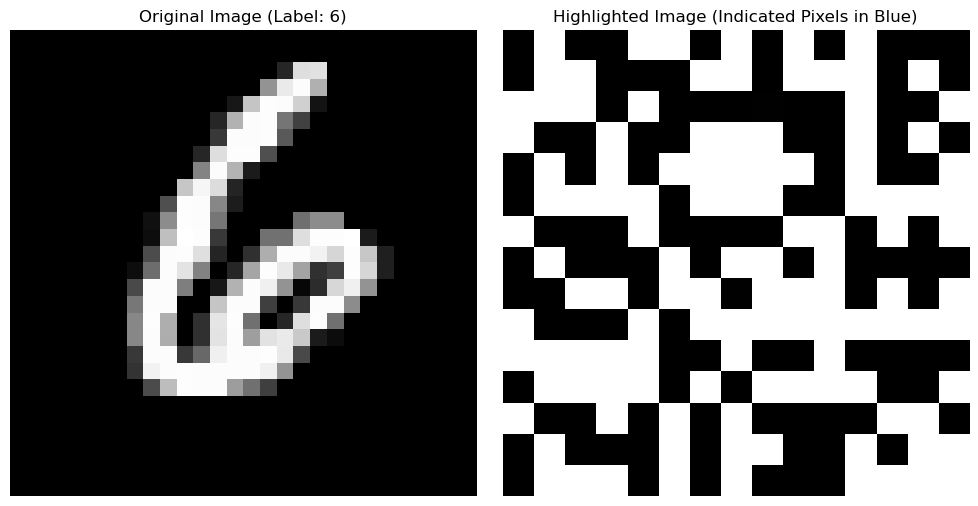

In [88]:
image = combined_images[indices_6[0]]

# Assume you have a 1D binary array indicating some pixels (replace this with your 1D binary array)
binary_array_1d = np.array(solution)

cond = binary_array_1d == 1
bad_inds = np.where(cond)

# Convert the 1D binary array back to a 2D binary mask
image_shape = image.shape
binary_array_2d = binary_array_1d.reshape(15,15)

# Create a copy of the image to avoid modifying the original image
highlighted_image = np.copy(normalized_images[indices_6[0]])
# highlighted_image = np.zeros(image_shape)
highlighted_image[bad_inds] = 255
highlighted_image = highlighted_image.reshape(15,15)
# Set the pixels indicated by the binary mask to a specified color (e.g., blue)
# highlighted_image[binary_array_2d == 1] = 255   # R: 0, G: 0, B: 255 (blue color)

# Plot the original image and the highlighted image side by side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title(f'Original Image (Label: {combined_labels[indices_6[0]]})')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(highlighted_image, cmap='gray')
plt.title('Highlighted Image (Indicated Pixels in Blue)')
plt.axis('off')

plt.tight_layout()
plt.show()
